In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

os.chdir("C:/Users/jerem/OneDrive/Documents/rocketleague_ml")
file_name = "debug"

processed_file = f"data/processed/{file_name}.csv"
game = pd.read_csv(processed_file, low_memory=False) # type: ignore

In [ ]:
# type: ignore
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import Button, HBox, VBox, Output

def step_through_positions(game, player, fps=30, window_s=0.5):
    """
    Step through player and ball positions in time windows using buttons.
    """
    # Rocket League field dimensions
    field_x = (-4096, 4096)
    field_y = (-5120, 5120)

    # Column names
    hit_col = f"{player}_hit_ball_first_contact_impulse_x"
    ball_x, ball_y = "ball_positioning_x", "ball_positioning_y"
    player_x, player_y = f"{player}_positioning_x", f"{player}_positioning_y"
    time_col = "match_time" if "match_time" in game.columns else None

    # Create time if missing
    if not time_col:
        game = game.copy()
        game["match_time"] = game.index / fps
        time_col = "match_time"

    # Clean and tag hits
    df = game.dropna(subset=[ball_x, ball_y, player_x, player_y]).copy()
    df["hit"] = ~df[hit_col].isna()
    total_time = df[time_col].max()

    # Initial window setup
    current_time = [0.0]  # mutable for inner function access
    out = Output()

    def plot_window():
        start_time = current_time[0]
        end_time = start_time + window_s
        subset = df[(df[time_col] >= start_time) & (df[time_col] < end_time)]

        with out:
                out.clear_output(wait=True)
                fig, ax = plt.subplots(figsize=(12, 8))
                ax.set_xlim(field_x)
                ax.set_ylim(field_y)
                ax.set_aspect("equal", adjustable="box")
                ax.set_title(f"{player} & Ball | {start_time:.2f}s–{end_time:.2f}s")
                ax.set_xlabel("X position")
                ax.set_ylabel("Y position")
                ax.grid(alpha=0.3)

                # Ball
                ax.scatter(
                    subset[ball_x], subset[ball_y],
                    c=np.where(subset["hit"], "red", "gray"),
                    alpha=0.6, label="Ball (red = hit)"
                )

                # Player
                ax.scatter(
                    subset[player_x], subset[player_y],
                    c=np.where(subset["hit"], "blue", "lightblue"),
                    alpha=0.6, label=f"{player} (blue = hit)"
                )

                # Table data: times and hit status
                table_data = []
                for t, hit in zip(subset[time_col], subset["hit"]):
                    table_data.append([f"{t:.3f}", "Yes" if hit else "No"])

                if table_data:
                    # Create a small table on the right
                    table = ax.table(
                        cellText=table_data,
                        colLabels=["Time (s)", "Hit?"],
                        colWidths=[0.2, 0.1],
                        loc="right",
                        cellLoc="center",
                        colLoc="center"
                    )
                    table.auto_set_font_size(False)
                    table.set_fontsize(10)
                    table.scale(1, 1.5)

                ax.legend()
                plt.show()

    def on_next_clicked(_):
        if current_time[0] + window_s < total_time:
            current_time[0] += window_s
            plot_window()

    def on_prev_clicked(_):
        if current_time[0] - window_s >= 0:
            current_time[0] -= window_s
            plot_window()

    # Buttons
    next_button = Button(description="Next ▶", button_style="success")
    prev_button = Button(description="◀ Prev", button_style="info")
    next_button.on_click(on_next_clicked)
    prev_button.on_click(on_prev_clicked)

    display(VBox([HBox([prev_button, next_button]), out]))
    plot_window()

step_through_positions(game, "Captain_zay", fps=30, window_s=0.5)


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


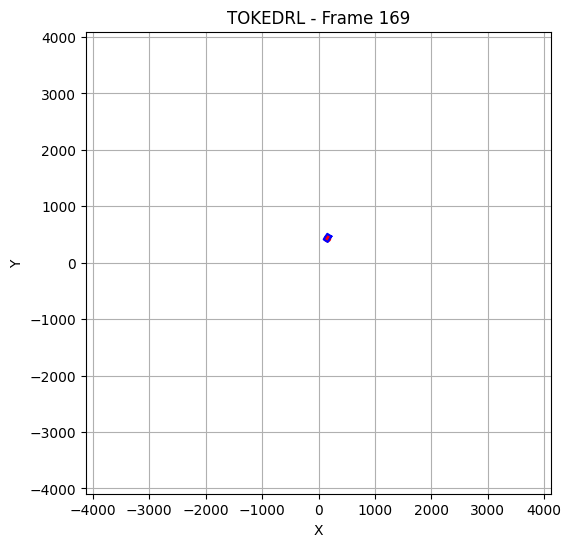

In [ ]:

def quat_to_yaw(x, y, z, w):
    # Convert quaternion to yaw (rotation around Z axis)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    return np.arctan2(siny_cosp, cosy_cosp)

def plot_car_2d(df, player, frame_idx, car_length=118, car_width=84):
    # Position
    cx = df.loc[frame_idx, f"{player}_positioning_x"]
    cy = df.loc[frame_idx, f"{player}_positioning_y"]

    # Rotation
    qx = df.loc[frame_idx, f"{player}_positioning_rotation_x"]
    qy = df.loc[frame_idx, f"{player}_positioning_rotation_y"]
    qz = df.loc[frame_idx, f"{player}_positioning_rotation_z"]
    qw = df.loc[frame_idx, f"{player}_positioning_rotation_w"]

    yaw = quat_to_yaw(qx, qy, qz, qw)

    # Car rectangle (centered)
    half_l = car_length / 2
    half_w = car_width / 2
    corners = np.array([
        [-half_l, -half_w],
        [ half_l, -half_w],
        [ half_l,  half_w],
        [-half_l,  half_w],
        [-half_l, -half_w]
    ])

    # Rotate the rectangle
    rot = np.array([
        [np.cos(yaw), -np.sin(yaw)],
        [np.sin(yaw),  np.cos(yaw)]
    ])
    rotated = corners @ rot.T
    rotated[:, 0] = -rotated[:, 0]
    cx = -cx

    # Translate to car center
    rotated[:, 0] += cx
    rotated[:, 1] += cy


    # Plot
    # Rocket League field dimensions (uu)
    field_length = 10280  # along Y axis
    field_width = 8240  # along X axis

    plt.figure(figsize=(6, 6))
    plt.plot(rotated[:, 0], rotated[:, 1], color='blue')
    plt.scatter(cx, cy, color='red', s=20)
    plt.title(f"{player} - Frame {frame_idx}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('equal')
    plt.grid(True)
    plt.xlim(-field_width / 2, field_width / 2)
    plt.ylim(-field_length / 2, field_length / 2)

plot_car_2d(game, "TOKEDRL", 169)
plot_car_2d(game, "Captain_zay", 169)
plt.show()